# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [4]:
# See the cardinality
pd.DataFrame({'label': df.columns,
              'unique values':[len(np.unique(df[x].astype(str))) for x in df.columns]})

,label,unique values
0,encounter_id,101766
1,patient_nbr,71518
2,race,6
3,gender,3
4,age,10
5,weight,10
6,admission_type_id,8
7,discharge_disposition_id,26
8,admission_source_id,17
9,time_in_hospital,14


In [5]:
# See if it's in the encounter level
try:
    assert(len(df)==len(np.unique(df['encounter_id'])))
    print('Is the encounter level')
except:
    print('Is not the encounter level')

Is not the encounter level


In [6]:
# See if it's in the longitudinal level
try:
    assert(len(df)==len(np.unique(df['patient_nbr'])))
    print('Is the longitudinal level')
except:
    print('Is not the longitudinal level')

Is not the longitudinal level


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

**Student Response:** Because is not the encounter or longitudinal level we can affirm we are at the line level. As we have seen, there is any feature which is unique in each sample, so we have to aggregate into the encounter level.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


### a. Field(s) with high amount of missing/zero values

In [7]:
# See how many nulls we have
np.sum(df.isnull(), axis=0)

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
primary_diagnosis_code          0
other_diagnosis_codes           0
number_outpatient               0
number_inpatient                0
number_emergency                0
num_lab_procedures              0
number_diagnoses                0
num_medications                 0
num_procedures                  0
ndc_code                    23462
max_glu_serum                   0
A1Cresult                       0
change                          0
readmitted                      0
dtype: int64

In [8]:
# We see there are some features which have '?' which is equivalent to null
np.sum(df.isin(['?']), axis=0)

encounter_id                     0
patient_nbr                      0
race                          3309
gender                           0
age                              0
weight                      139122
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                   54190
medical_specialty            69463
primary_diagnosis_code          33
other_diagnosis_codes            0
number_outpatient                0
number_inpatient                 0
number_emergency                 0
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures                   0
ndc_code                         0
max_glu_serum                    0
A1Cresult                        0
change                           0
readmitted                       0
dtype: int64

**High amount of missing values in weight column.**

In [9]:
np.sum(df.isin([0]), axis=0)

encounter_id                     0
patient_nbr                      0
race                             0
gender                           0
age                              0
weight                           0
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                       0
medical_specialty                0
primary_diagnosis_code           0
other_diagnosis_codes            0
number_outpatient           120027
number_inpatient             96698
number_emergency            127444
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures               65788
ndc_code                         0
max_glu_serum                    0
A1Cresult                        0
change                           0
readmitted                       0
dtype: int64

### b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?

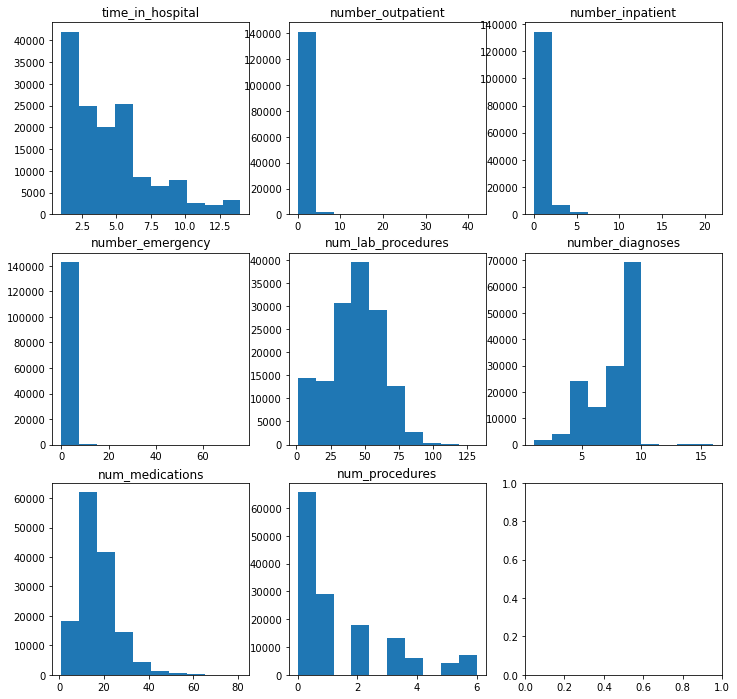

In [10]:
numerical_col = ['time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency',
                 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']

_, ax = plt.subplots(3,3, figsize=(12,12))
ax = ax.flatten()
for i in range(8):
    ax[i].hist(df[numerical_col[i]])
    ax[i].set_title(numerical_col[i])

**Answer:** the age and the number of medications follow a normal distribution. In the other cases, the distribution is different and, in case of the time in hospital, which is the one we want to predict, there is an exponentially decreased distribution.

### c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)

In [11]:
numerical_id_col = ['encounter_id', 'patient_nbr']
categorical_col = [x for x in df.columns if x not in numerical_col + numerical_id_col]
pd.Series(data = [len(np.unique(df[x].astype(str))) for x in categorical_col], index = categorical_col)

race                            6
gender                          3
age                            10
weight                         10
admission_type_id               8
discharge_disposition_id       26
admission_source_id            17
payer_code                     18
medical_specialty              73
primary_diagnosis_code        717
other_diagnosis_codes       19374
ndc_code                      252
max_glu_serum                   4
A1Cresult                       4
change                          2
readmitted                      3
dtype: int64

**Answer:** there are some categorical features with high cardinality such as `primary_diagnosis_code`, `other_diagnosis_codes`, `ndc_code`. There are others like `medical_specility` and `discharge_disposition_id` which can be considered as high cardinality, but in this case we are not going to consider as it.

Others like `encounter_id` and `patient_nbr` are numerical ID's, so they are not considered as categorical.

This is because are different id's for different encounters, patients, diagnosis codes. Because we have many patients, the amount of encounters is also high and many different diagnosis are included. The high cardinality of these fields was expected because we are working with high amount of data.

### Distribution age and gender

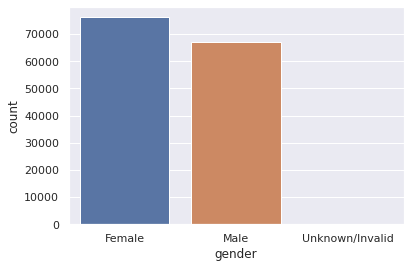

In [12]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="gender", data=df)

**Answer:** almost same amount fo male and female in our dataset, and small amount of smalll and unknown, which will make the model worst.

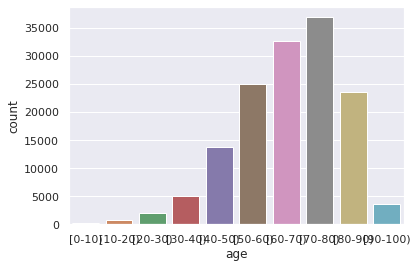

In [15]:
ax = sns.countplot(x="age", data=df)

**Answer:** normal distribution with most of people between 40 an 80 but samples of all groups. This shows that our study will be made at old people mostly because they are more susceptible to have diabetes. The distribution is correct and won't bias our model.

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: Problems when using the library.

In [16]:
import tensorflow_data_validation as tfdv

Error importing tfx_bsl_extension.arrow.array_util. Some tfx_bsl functionalities are not availableError importing tfx_bsl_extension.arrow.table_util. Some tfx_bsl functionalities are not availableError importing tfx_bsl_extension.arrow.table_util. Some tfx_bsl functionalities are not available

In [17]:
######NOTE: The visualization will only display in Chrome browser. ########
full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
tfdv.visualize_statistics(full_data_stats)

/opt/conda/lib/python3.7/site-packages/tensorflow_data_validation/arrow/arrow_util.py:236: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  types.FeaturePath([column_name]), column.data.chunk(0), weights):


AttributeError: module 'tfx_bsl.arrow.array_util' has no attribute 'ListLengthsFromListArray' [while running 'GenerateStatistics/RunStatsGenerators/GenerateSlicedStatisticsImpl/RunCombinerStatsGenerators/WindowIntoDiscarding']

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [18]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [19]:
ndc_code_df

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
...,...,...,...,...,...,...,...
264,0781-5635,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
265,64764-302,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
266,64764-304,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
267,66993-821,Pioglitazone And Glimepiride,Pioglitazone And Glimepiride,Tablet,Oral,Prasco Laboratories,Human Prescription Drug


In [20]:
def reduce_dimension_ndc(df, ndc_df):
    '''
    df: pandas dataframe, input dataset
    ndc_df: pandas dataframe, drug code dataset used for mapping in generic names
    return:
        df: pandas dataframe, output dataframe with joined generic drug name
    '''
    
    df['generic_drug_name'] = df['ndc_code'].replace(dict(zip(ndc_df['NDC_Code'], ndc_df['Proprietary Name'])))
    
    return df

In [21]:
#from student_utils import reduce_dimension_ndc
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [22]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [23]:
reduce_dim_df.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Novolin R
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,Glipizide


In [24]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [25]:
first_encounter_df = select_first_encounter(reduce_dim_df)
first_encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
12,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,47918-902,None,None,Ch,NO,Afrezza
11,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,Glucotrol
14,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Novolin R
13,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,0173-0863,None,None,Ch,NO,Avandia 4MG
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glucotrol


In [26]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [27]:
exclusion_list = ['generic_drug_name', 'ndc_code']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [28]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()
print('Everything okay!')

Everything okay!


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

**Student response:** for the payer_code we are going to exclude from our model because it does not give relevant information because won't affect at the response to the treatment, so we are going to exclude. In the case of weight, because there is a high amount of missing values, despite is a categorical feature, we are going to exclude because does not give relevant information to our model. Both have a high degree of disparsity, so they are not going to be used in our model.

In [29]:
df.head(2)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Novolin R


In [30]:
np.unique(df['payer_code']), np.sum(df['payer_code']=='?')*100/len(df)

(array(['?', 'BC', 'CH', 'CM', 'CP', 'DM', 'FR', 'HM', 'MC', 'MD', 'MP',
        'OG', 'OT', 'PO', 'SI', 'SP', 'UN', 'WC'], dtype=object),
 37.783076751450245)

In [31]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ["medical_specialty", "primary_diagnosis_code"]+ required_demo_col_list + ndc_col_list
student_numerical_col_list = ['number_outpatient', 'number_inpatient', 'number_emergency',
                              'num_medications', 'num_procedures']
PREDICTOR_FIELD = 'time_in_hospital'

In [32]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [33]:
agg_drug_df.head(2)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hcl,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,None,None,Ch,NO,"[Afrezza, Glucotrol]",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,None,None,Ch,NO,"[Novolin R, Avandia 4MG]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

**Answer:** this approach gives a solution to possible problems with data types, so we won't have to change later.

In [35]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [36]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [37]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [38]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


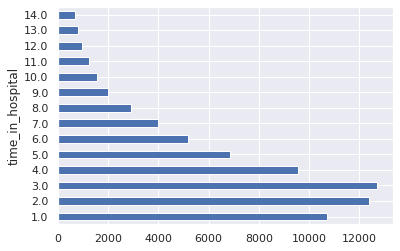

In [39]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6430
2.0     7378
3.0     7613
4.0     5773
5.0     4101
6.0     3055
7.0     2426
8.0     1775
9.0     1218
10.0     935
11.0     738
12.0     580
13.0     494
14.0     395
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


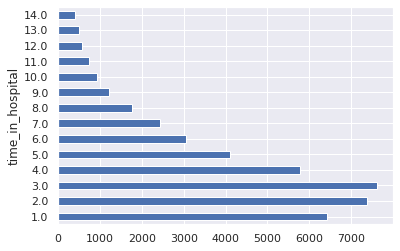

In [40]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2149
2.0     2473
3.0     2543
4.0     1912
5.0     1396
6.0     1027
7.0      830
8.0      553
9.0      376
10.0     313
11.0     234
12.0     195
13.0     156
14.0     146
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


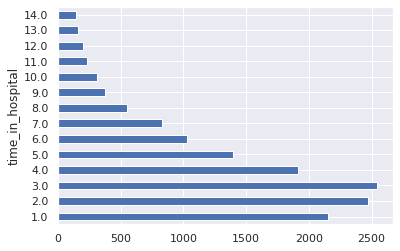

In [41]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

**Answer:** the distribution of time in hospital are similar above all partitions, so we can consider there is no data leakage which can alter our model.

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


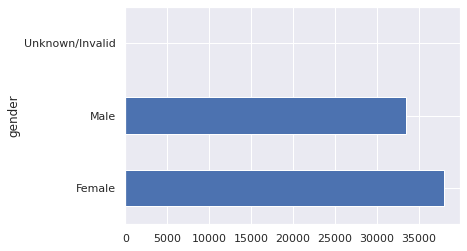

In [42]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22762
Male               20147
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


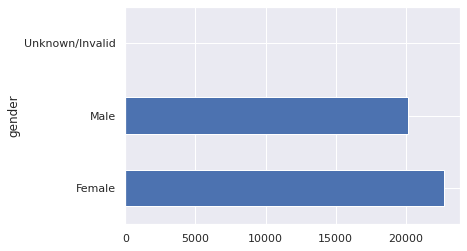

In [43]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             7606
Male               6696
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


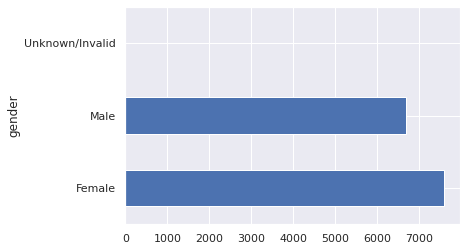

In [44]:
# Test partition
show_group_stats_viz(d_test, 'gender')

**Answer:** the sex distribution is quite similar in all groups, so we can also confirm we avoid data leakage.

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [45]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [46]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [47]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [48]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 69 in medical_specialty is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/medical_specialty_vocab.txt.


INFO:tensorflow:vocabulary_size = 69 in medical_specialty is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/medical_specialty_vocab.txt.


INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.


INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.


INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.


INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Acarbose is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Acarbose_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Afrezza is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Afrezza_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Afrezza is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Afrezza_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Amaryl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Amaryl_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Amaryl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Amaryl_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Avandia_2MG is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Avandia_2MG_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Avandia_2MG is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Avandia_2MG_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Avandia_4MG is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Avandia_4MG_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Avandia_4MG is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Avandia_4MG_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glimepiride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glimepiride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glipizide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glipizide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glipizide_And_Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt.


INFO:tensorflow:vocabulary_size = 3 in Glipizide_And_Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glipizide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glipizide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glucophage is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glucophage_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glucophage is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glucophage_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glucophage_XR is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glucophage_XR_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glucophage_XR is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glucophage_XR_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glucotrol is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glucotrol_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glucotrol is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glucotrol_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glucotrol_XL is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glucotrol_XL_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glucotrol_XL is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glucotrol_XL_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glyburide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glyburide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glyburide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glyburide_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glyburide-metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glyburide-metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glynase is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glynase_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glynase is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glynase_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glyset is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyset_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Glyset is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Glyset_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Humulin_R is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Humulin_R_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Humulin_R is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Humulin_R_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hcl_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Metformin_Hcl is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hcl_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Metformin_Hydrochloride_Extended_Release is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hydrochloride_Extended_Release_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Metformin_Hydrochloride_Extended_Release is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Metformin_Hydrochloride_Extended_Release_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Miglitol is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Miglitol_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Miglitol is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Miglitol_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Nateglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Nateglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Nateglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Nateglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Novolin_R is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Novolin_R_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Novolin_R is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Novolin_R_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Pioglitazole_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazole_And_Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Pioglitazole_And_Metformin_Hydrochloride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazole_And_Metformin_Hydrochloride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Pioglitazone is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Pioglitazone is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Pioglitazone_Hydrochloride_And_Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_Hydrochloride_And_Glimepiride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Pioglitazone_Hydrochloride_And_Glimepiride is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Pioglitazone_Hydrochloride_And_Glimepiride_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Prandin is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Prandin_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Prandin is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Prandin_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Repaglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Repaglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Repaglinide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Repaglinide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Riomet is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Riomet_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Riomet is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Riomet_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Riomet_Er is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Riomet_Er_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Riomet_Er is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Riomet_Er_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Starlix is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Starlix_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Starlix is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Starlix_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Tolazamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolazamide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Tolazamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolazamide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Tolbutamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolbutamide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in Tolbutamide is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolbutamide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolbutamide_vocab.txt.


INFO:tensorflow:vocabulary_size = 4 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/Tolbutamide_vocab.txt.


In [49]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='medical_specialty', vocabulary_file='./diabetes_vocab/medical_specialty_vocab.txt', vocabulary_size=69, num_oov_buckets=0, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


tf.Tensor(
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(128, 69), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [50]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [53]:
# Change '?' for np.nan to convert all the column to floats
d_train[student_numerical_col_list] = d_train[student_numerical_col_list].replace('?', np.nan)
d_train[student_numerical_col_list] = d_train[student_numerical_col_list].astype(float)

In [54]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        col = train_df[c]
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std, train_df)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [55]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [56]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='number_outpatient', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [5.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [9.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [4.]
 [0.]
 [0.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [4.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(128, 1), dtype=float32)


# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [57]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [58]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=10)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [59]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=30)

Train for 336 steps, validate for 112 steps
Epoch 1/30
336/336 [==============================] - 11s 33ms/step - loss: 33.4532 - mse: 33.3693 - val_loss: 27.8610 - val_mse: 27.6594
Epoch 2/30
336/336 [==============================] - 6s 18ms/step - loss: 24.8166 - mse: 24.5305 - val_loss: 18.6951 - val_mse: 18.0280
Epoch 3/30
336/336 [==============================] - 6s 18ms/step - loss: 18.3068 - mse: 17.7250 - val_loss: 15.9883 - val_mse: 15.0948
Epoch 4/30
336/336 [==============================] - 7s 20ms/step - loss: 14.7519 - mse: 13.9957 - val_loss: 14.7884 - val_mse: 13.9326
Epoch 5/30
336/336 [==============================] - 7s 21ms/step - loss: 13.6112 - mse: 12.7045 - val_loss: 12.1120 - val_mse: 11.1514
Epoch 6/30
336/336 [==============================] - 8s 25ms/step - loss: 11.9286 - mse: 10.9737 - val_loss: 11.2935 - val_mse: 10.2885
Epoch 7/30
336/336 [==============================] - 6s 18ms/step - loss: 11.1659 - mse: 10.2390 - val_loss: 10.2923 - val_mse: 9.53

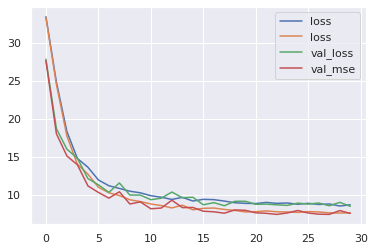

In [60]:
plt.plot(range(30), history.history['loss'], label='loss')
plt.plot(range(30), history.history['mse'], label='loss')
plt.plot(range(30), history.history['val_loss'], label='val_loss')
plt.plot(range(30), history.history['val_mse'], label='val_mse')
plt.legend();

**Answer:** the loss and the mse decrease which epochs but after 15 it remains almost equal, so we consider 30 as a good value and we also avoid overfitting.

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [61]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [62]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [63]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [64]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,5.213347,7.0,5.485279,0.692683
1,8.101966,5.0,3.711984,0.692561
2,3.712672,6.0,6.052052,0.685625
3,8.405431,2.0,1.537906,0.696385
4,4.712131,5.0,2.928717,0.692175


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [65]:
prob_output_df

,pred,actual_value,pred_mean,pred_std
0,5.213347,7.0,5.485279,0.692683
1,8.101966,5.0,3.711984,0.692561
2,3.712672,6.0,6.052052,0.685625
3,8.405431,2.0,1.537906,0.696385
4,4.712131,5.0,2.928717,0.692175
...,...,...,...,...
14298,4.170093,7.0,3.830857,0.691665
14299,3.024760,1.0,3.829010,0.692729
14300,2.821375,1.0,2.544281,0.693428
14301,5.392752,2.0,3.139238,0.693109


In [66]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [67]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [68]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,43554789,Female,Caucasian,7.0,1,1
1,90582885,Male,Caucasian,5.0,0,1
2,20139570,Female,Caucasian,6.0,1,1
3,7273179,Male,Caucasian,2.0,0,0
4,94586832,Female,AfricanAmerican,5.0,0,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [69]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

y_true = pred_test_df['label_value']
y_pred = pred_test_df['score']
# AUC, F1, precision and recall
auc = roc_auc_score(y_true, y_pred)
print('ROC AUC score: {}'.format(auc))

f1 = f1_score(y_true, y_pred)
print('F1-Score: {}'.format(f1))

acc = accuracy_score(y_true, y_pred)
print('Accuracy score: {}\n\n'.format(acc))

# Summary
print(classification_report(y_true, y_pred))

ROC AUC score: 0.5969950777464109
F1-Score: 0.35174375093548876
Accuracy score: 0.6971963923652381


              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9077
           1       0.81      0.22      0.35      5226

    accuracy                           0.70     14303
   macro avg       0.75      0.60      0.58     14303
weighted avg       0.73      0.70      0.64     14303



**Answer:** the precision-recall tradeoff takes into account an equilibrium between precision and recall to get the best results. Instead, if we have high precision, the recall will be low and same will occur for high recall. It's important to have an equilibrium.

Something to include for future iterations is change the number of epochs, change the dense layers and the optimizer. Different experiments have to be done to improve the obtained results.

The **precision** gives the true positive among all positive values, so it takes into account false positives. In our case, we have good values for precision, which indicates that we can detect with precision those positives ones.

The **recall** is a metric which measures the true positives among all the labels which were really positive. We get a good result for those who we consider in our model but bad results for those who are rejected. That indicates that we are dropping some patients of our study which had to be taken into account for future improvements.

Because we get correct values of accuracy and recall, we can consider our project as valid because we will identify correctly which patients to test the drug, however it would be preferable to have higher precision values, specially for label 0. In this case we are interested in high values of precision because we don't want to have many false positives which will translate into more time and money, so a low value of recall won't be as bad as precision. For this reason, while we want an equilibrium as is told in the tradeoff, we prefer better values of precision.

To decide which levels of recall and precision are correct, we can compare to other studies and see how they worked.

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [70]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [1455]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [71]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

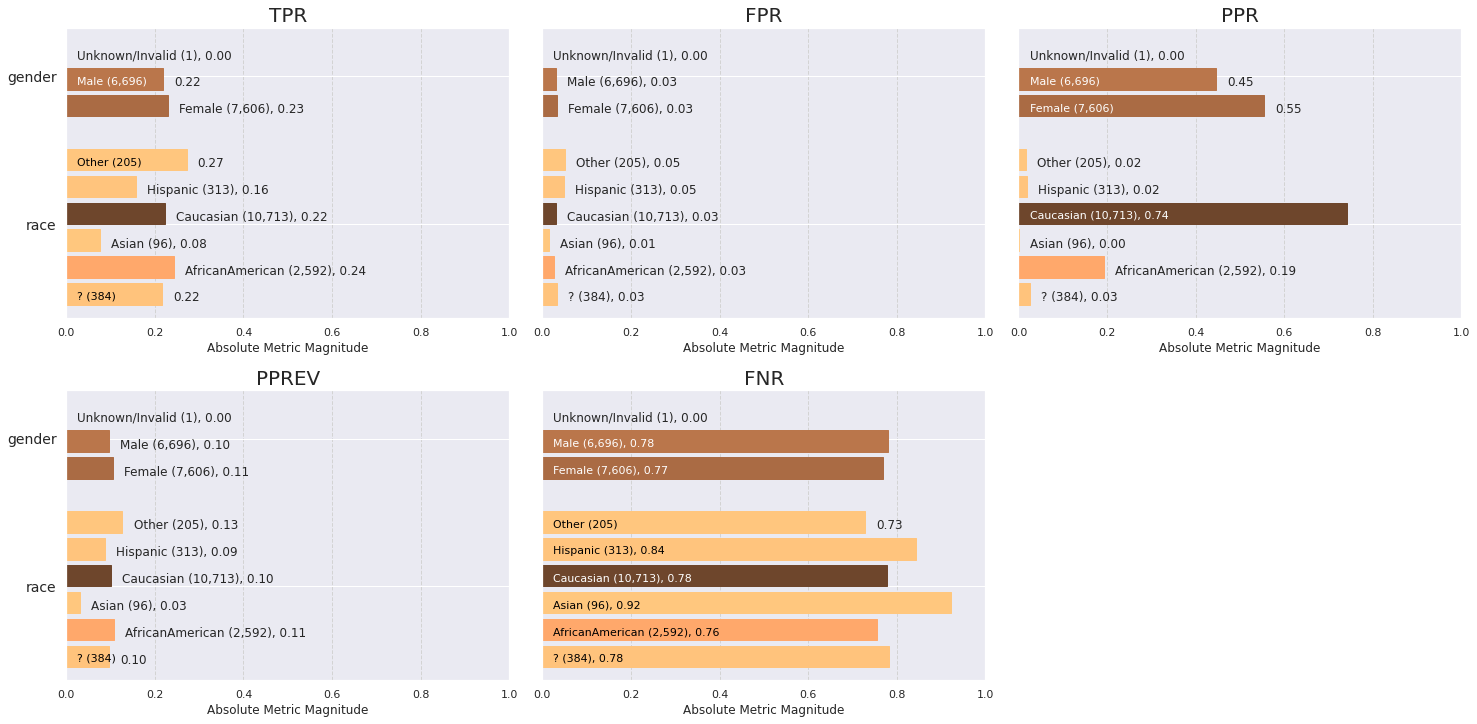

In [72]:
# Plot two metrics
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'])

# Is there significant bias in your model for either race or gender?

**Answer:** there is a bias in race for for PPR with caucasian and African American, so it's a point where we can improve our model, we are going to see in more detail in the following graphs. The true and false positive have similar values of sex and race, same happens with PPREV and false negative rate.

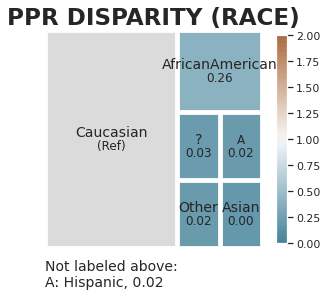

In [73]:
ppr_disparity = aqp.plot_disparity(bdf, group_metric='ppr_disparity', 
                                       attribute_name='race')

**Answer:** the PPR disparity shows the predicted positive rate, which has bias considering that we have large amount of caucasian, which represents 4 times the African American ones and more than 30 times the other ones.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

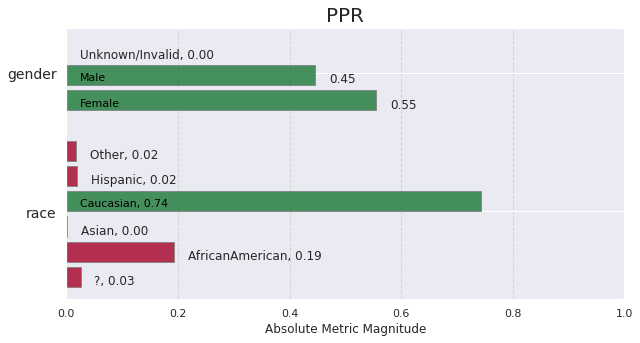

In [74]:
ppr_fairness = aqp.plot_fairness_group(fdf, group_metric='ppr', title=True)

**Answer:** There's fairness in gender for PPR but not for race, where gender has a bigger magnitude than other races. So, in this case,  results are not independent of this variable.